In [1]:
%load_ext autoreload
%autoreload 1
from seispy.decon import RFTrace
import os

from matplotlib import pyplot as plt
import obspy
import pandas as pd

from insight.rotate import polarization_azimuth, angle_err
from insight.util import TraceFile, rf_plot, trace_plot

# Parameters

In [2]:
DATA_DIR = "../data/"
network = "XB"
station = "ELYSE"
location = "02"
bandpass = {"freqmin": 0.25, "freqmax": 1.0}
before, after = 10, 120

## Read events back from disk

In [3]:
st_zne = {}
events = pd.read_parquet(os.path.join(DATA_DIR, "a_quality.parquet"))
for evt in events.index:
    trace_file = TraceFile(network, station, location, events.loc[evt].id)
    st_zne[evt] = obspy.read(os.path.join(DATA_DIR, "zne", str(trace_file)))

## Bandpass & DeTrend

In [4]:
for evt in events.index:
    st_zne[evt].detrend()
    st_zne[evt].filter(type="bandpass", **bandpass)

## Determine Polarisation

In [5]:
pa = {}

for evt in events.index:
    pa[evt] = polarization_azimuth(st_zne[evt], offset=before)._asdict()


In [6]:
events = events.join(pd.DataFrame(pa).T)
events["angle_err"] = events.apply(lambda e: angle_err(e.azimuth, float(e.mqs_azimuth)), axis=1)
events

,id,region name,time,quality,mqs_azimuth,mqs_distance,est_p_arrival,M_w,azimuth,incident_angle,angle_err
earthquake name,,,,,,,,,,,
S1222a,mqs2022isne,Aeolis Northeast,2022-05-04T23:23:07.710516Z,A,109.000000,37.014014,2022-05-04T23:27:34.0Z,4.6,121.014529,45.390180,12.014529
S1094b,mqs2021zdzn,Diacria Southwest,2021-12-24T22:38:02.749173Z,A,40.000000,59.653654,2021-12-24T22:44:48.7Z,4.0,36.610129,17.415993,3.389871
S1133c,mqs2022cixp,Elysium Southeast,2022-02-03T08:04:36.469259Z,A,90.000000,30.006507,2022-02-03T08:08:11.7Z,3.8,91.909440,22.293816,1.909440
S0235b,mqs2019onhx,Elysium Southeast,2019-07-26T12:15:38.748239Z,A,258.030468,28.748749,2019-07-26T12:18:58.5Z,3.7,105.323548,13.974589,152.706920
S0173a,mqs2019jzqa,Elysium Southeast,2019-05-23T02:19:09.852879Z,A,91.000000,30.006507,2019-05-23T02:22:42.3Z,3.7,85.656708,31.084559,5.343292
S1048d,mqs2021vwbn,Elysium Southeast,2021-11-07T22:00:15.254098Z,A,100.000000,30.186186,2021-11-07T22:03:42.7Z,3.6,179.558334,32.616044,79.558334
S1022a,mqs2021tyvj,Elysium Northeast,2021-10-11T23:14:29.105382Z,A,63.000000,30.725225,2021-10-11T23:18:25.025302Z,3.6,82.681449,27.738957,19.681449
S0820a,mqs2021fjzq,Aeolis Northeast,2021-03-18T14:51:33.869889Z,A,88.000000,30.186186,2021-03-18T14:54:39.0Z,3.3,3.801175,42.514166,84.198825
S0809a,mqs2021eppu,Elysium Southeast,2021-03-07T11:09:26.99714Z,A,87.000000,29.826827,2021-03-07T11:12:59.6Z,3.3,99.121931,34.597909,12.121931


In [7]:
events_flt = events[events["angle_err"] < 15]
events_flt

,id,region name,time,quality,mqs_azimuth,mqs_distance,est_p_arrival,M_w,azimuth,incident_angle,angle_err
earthquake name,,,,,,,,,,,
S1222a,mqs2022isne,Aeolis Northeast,2022-05-04T23:23:07.710516Z,A,109.0,37.014014,2022-05-04T23:27:34.0Z,4.6,121.014529,45.390180,12.014529
S1094b,mqs2021zdzn,Diacria Southwest,2021-12-24T22:38:02.749173Z,A,40.0,59.653654,2021-12-24T22:44:48.7Z,4.0,36.610129,17.415993,3.389871
S1133c,mqs2022cixp,Elysium Southeast,2022-02-03T08:04:36.469259Z,A,90.0,30.006507,2022-02-03T08:08:11.7Z,3.8,91.909440,22.293816,1.909440
S0173a,mqs2019jzqa,Elysium Southeast,2019-05-23T02:19:09.852879Z,A,91.0,30.006507,2019-05-23T02:22:42.3Z,3.7,85.656708,31.084559,5.343292
S0809a,mqs2021eppu,Elysium Southeast,2021-03-07T11:09:26.99714Z,A,87.0,29.826827,2021-03-07T11:12:59.6Z,3.3,99.121931,34.597909,12.121931


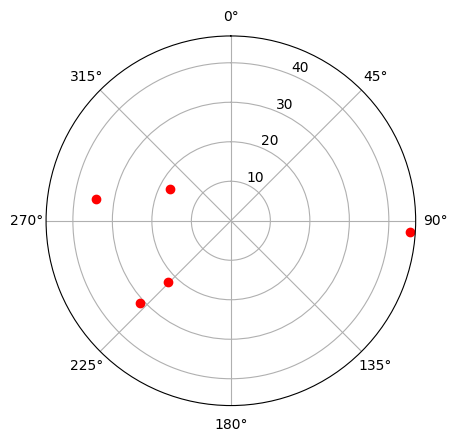

In [8]:
# Plot
ax = plt.subplot(111, polar=True)
ax.plot(events_flt["azimuth"], events_flt["incident_angle"], "ro")
ax.set_theta_direction(-1)
ax.set_theta_zero_location("N")

In [9]:
st_zrt = {}
for evt in events_flt.index:
    st_zrt[evt] = st_zne[evt].copy().rotate(method="NE->RT", back_azimuth=events.loc[evt].mqs_azimuth)

In [10]:
prfs = {}
f0 = 2.0
itmax = 400
minderr = 0.001

for evt in events_flt.index:
    prfs[evt] = RFTrace.deconvolute(
        st_zrt[evt][1], st_zrt[evt][2], method='iter',
        tshift=before, f0=f0, itmax=itmax,
        minderr=minderr)

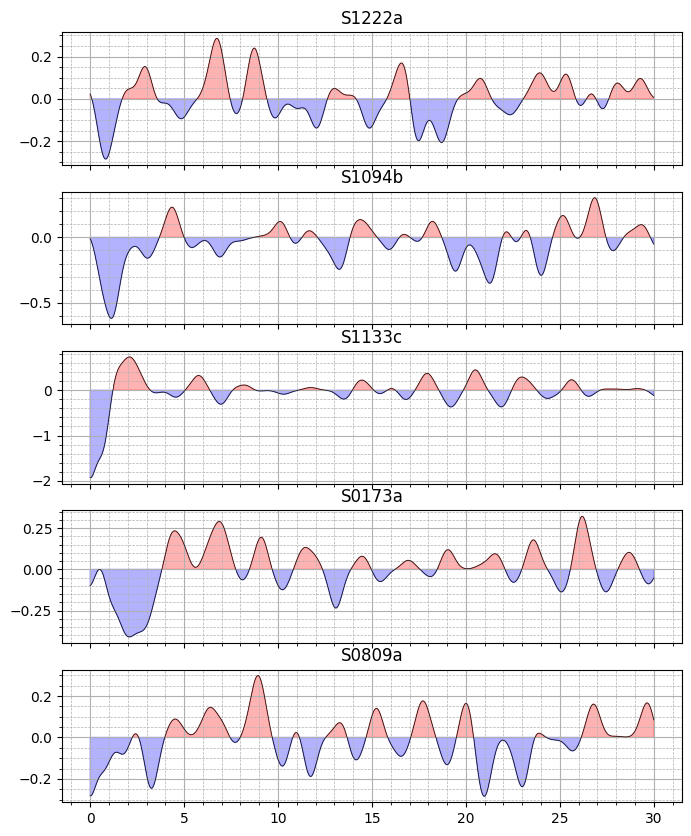

In [11]:
fig, axs = plt.subplots(len(events_flt), 1, figsize=(8, 10), dpi=100, sharex=True)
# axs[0].set_ylim(-1, 1)
# axs[0].imshow(img, extent=(0, 25, -1, 1), aspect="auto")

i = 0
for evt in events_flt.index:
    ax = axs[i]
    ax.set_title(evt)
    ax.grid(which="major")
    ax.grid(which="minor", linestyle="--", linewidth=.5)
    ax.minorticks_on()
    rf_plot(axs[i], prfs[evt])
    i += 1

In [ ]:
st_lqt = {}
for evt in events.index:
    e = events.loc[evt]
    st_lqt[evt] = st_zne[evt].copy().rotate(method="ZNE->LQT", back_azimuth=e.azimuth,
                                            inclination=e.incident_angle)
    # st_lqt[evt].plot(type="relative")

In [ ]:
prf2 = {}
for evt in events_flt.index:
    prf2[evt] = RFTrace.deconvolute(
        st_zrt[evt][1], st_zrt[evt][2], method='iter',
        tshift=before, f0=f0, itmax=itmax,
        minderr=minderr)

In [ ]:
fig, axs = plt.subplots(len(events_flt), 4, figsize=(20, 12), dpi=100)  #, sharex=True)

i = 0
for evt in events_flt.index:
    ax = axs[i][0]
    ax.set_title(evt)
    ax.grid(which="major")
    ax.grid(which="minor", linestyle="--", linewidth=.5)
    ax.minorticks_on()
    rf_plot(ax, prf2[evt])
    for j in range(3):
        ax = axs[i][j + 1]
        ax.set_title("ZRT"[j])
        ax.set_yticks([])
        ax.grid(which="major")
        ax.grid(which="minor", linestyle="--", linewidth=.5)
        trace_plot(ax, st_lqt[evt].traces[j], start=0, end=40)
        # axs[i][j + 1].plot(st_lqt[evt].traces[j].data, linewidth=.5)
    i += 1

fig.tight_layout()